# PASCAL VOC DataLoader

## 1. Prepare PASCAL VOC2007 dataset.

In [1]:
## link: https://drive.google.com/file/d/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT/view?usp=sharing
## id: 1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT
## filename: VOC2007.zip

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT" -O VOC2007.zip && rm -rf ~/cookies.txt

--2022-06-21 05:05:36--  https://docs.google.com/uc?export=download&confirm=t&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT
Resolving docs.google.com (docs.google.com)... 142.251.42.142, 2404:6800:4004:825::200e
Connecting to docs.google.com (docs.google.com)|142.251.42.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7681ppcor3dbi36fshu0rv7tjrbvfgp9/1655787900000/16525786242263481678/*/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT?e=download [following]
--2022-06-21 05:05:36--  https://doc-04-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7681ppcor3dbi36fshu0rv7tjrbvfgp9/1655787900000/16525786242263481678/*/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT?e=download
Resolving doc-04-1k-docs.googleusercontent.com (doc-04-1k-docs.googleusercontent.com)... 172.217.175.65, 2404:6800:4004:81e::2001
Connecting to doc-04-1k-docs.googleusercontent.com (doc-04-1k-docs.goo

In [2]:
import zipfile
with zipfile.ZipFile('VOC2007.zip', 'r')as f:
    f.extractall('./')

!rm -rf VOC2007.zip
!rm -rf __MACOSX

## 2. Import packages.

In [3]:
import os

import numpy as np
import scipy.io as sio
import pickle
import torch
import torch.utils.data as data
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

In [4]:
VOC2007_CLASSES = (
    '__background__',
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
)

# Define bbox color
VOC2007_COLORS = [
    [0.,        0.,        0.       ],
 [0.5019608, 0.,        0.       ],
 [0.,        0.5019608, 0.       ],
 [0.5019608, 0.5019608, 0.       ],
 [0.,        0.,        0.5019608],
 [0.5019608, 0.,        0.5019608],
 [0.,        0.5019608, 0.5019608],
 [0.5019608, 0.5019608, 0.5019608],
 [0.2509804, 0.,        0.       ],
 [0.7529412, 0.,        0.       ],
 [0.2509804, 0.5019608, 0.       ],
 [0.7529412, 0.5019608, 0.       ],
 [0.2509804, 0.,        0.5019608],
 [0.7529412, 0.,        0.5019608],
 [0.2509804, 0.5019608, 0.5019608],
 [0.7529412, 0.5019608, 0.5019608],
 [0.,        0.2509804, 0.       ],
 [0.5019608, 0.2509804, 0.       ],
 [0.,        0.7529412, 0.       ],
 [0.5019608, 0.7529412, 0.       ],
 [0.,        0.2509804, 0.5019608]]

## 3. Load an annotation file (working with a XML file).

### xml file example
- open any xml file by web browsers

- output of "__getitems__" should be

>image : a PIL Image of size (H, W)  
>target : a dict containing the following key  
>>boxes (FloatTensor[N, 4]) :  the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H  
>>labels (Int64Tensor[N]) : the label for each bounding box  
>>image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation  
>>area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.  
>>iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation(all set zero) 

In [8]:
### Parse xml file
sample_idx = 1
filename = f'./VOC2007/Annotations/{sample_idx:06d}.xml'
tree = ET.parse(filename)

In [9]:
### explore xml file
root = tree.getroot()
print("root.tag:", root.tag)
for node in root:
    print(">>>>", node.tag)
print('\n')

print("node.tag:", node.tag)
for node2 in node:  ### iterate the final object
    print(f">>>> {node2.tag}: {node2.text}")
print("\n")

print("node2.tag:", node2.tag)
for node3 in node2: ### iterate the final bndbox (bounding box)
    print(f">>>> {node3.tag}: {node3.text}")

root.tag: annotation
>>>> folder
>>>> filename
>>>> source
>>>> owner
>>>> size
>>>> segmented
>>>> object
>>>> object


node.tag: object
>>>> name: person
>>>> pose: Left
>>>> truncated: 1
>>>> difficult: 0
>>>> bndbox: 
			


node2.tag: bndbox
>>>> xmin: 8
>>>> ymin: 12
>>>> xmax: 352
>>>> ymax: 498


### 3-1. Find all objects

In [10]:
objs = tree.findall('object')
num_objs = len(objs)
print("the number of objects:", num_objs)
print("objs:", objs) # List[Element]

for obj_idx, obj in enumerate(objs):
    for node in obj:
        print(f">>>> {obj_idx}th {node.tag}: {node.text}")
        for node2 in node:
            print(f">>>> {obj_idx}th bounding box's {node2.tag}: {node2.text}")
    print("")

the number of objects: 2
objs: [<Element 'object' at 0x7fb8a0762450>, <Element 'object' at 0x7fb8a0762180>]
>>>> 0th name: dog
>>>> 0th pose: Left
>>>> 0th truncated: 1
>>>> 0th difficult: 0
>>>> 0th bndbox: 
			
>>>> 0th bounding box's xmin: 48
>>>> 0th bounding box's ymin: 240
>>>> 0th bounding box's xmax: 195
>>>> 0th bounding box's ymax: 371

>>>> 1th name: person
>>>> 1th pose: Left
>>>> 1th truncated: 1
>>>> 1th difficult: 0
>>>> 1th bndbox: 
			
>>>> 1th bounding box's xmin: 8
>>>> 1th bounding box's ymin: 12
>>>> 1th bounding box's xmax: 352
>>>> 1th bounding box's ymax: 498



### 3-2. Obtain bounding boxes as np.ndarray.

In [11]:
boxes = np.zeros((num_objs, 4), dtype=np.int32)
classes = []
for obj_idx, obj in enumerate(objs):
    ###Get bounding boxes
    bbox = obj.find('bndbox')
    x1 = float(bbox.find('xmin').text) - 1 # correct coordinates
    y1 = float(bbox.find('ymin').text) - 1
    x2 = float(bbox.find('xmax').text) - 1
    y2 = float(bbox.find('ymax').text) - 1
    boxes[obj_idx, :] = [x1, y1, x2, y2]
    
    ###Get Categories
    object_class = obj.find('name').text   # class name *as string
    classes.append(object_class)
    
print(boxes)
print(classes)

[[ 47 239 194 370]
 [  7  11 351 497]]
['dog', 'person']


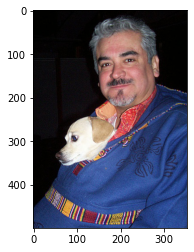

In [12]:
img = Image.open(f'./VOC2007/JPEGImages/{sample_idx:06d}.jpg')
fig, ax = plt.subplots(1)
ax.imshow(img)

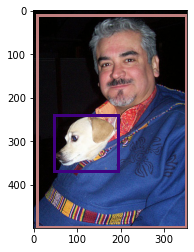

In [14]:
def draw_bb(img, boxes, classes, red_only=False):
    fig,ax = plt.subplots(1)
    for box, class_ in zip(boxes, classes):
        rect = patches.Rectangle(
            (box[0], box[1]), # the upper left point
            box[2]-box[0], # delta_x: width
            box[3]-box[1], # delta_y: height
            linewidth=3, # thickness
            edgecolor='r' if red_only else VOC2007_COLORS[VOC2007_CLASSES.index(class_)],
            facecolor='none'
        )
        ax.add_patch(rect)
    ax.imshow(img)

draw_bb(img, boxes, classes, False)

## 4. Define PASCAL VOC2007 dataset.

In [16]:
class PASCAL_DATASET(data.Dataset):
    def __init__(self, data_root, img_list_file):        
        self.data_root = data_root        
        self.img_list = []
        self._load_img_name_list(img_list_file)               

    def _load_img_name_list(self, img_list_file):
        with open(img_list_file) as f:
            self.img_list = f.read().splitlines()
                                  
    def _load_annotation(self, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml')
        tree = ET.parse(filename)
        objs = tree.findall('object')
        num_objs = len(objs)
        boxes = np.zeros((num_objs, 4), dtype=np.int32)
        gt_classes_str = []
        
        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            gt_classes_str.append(obj.find('name').text)
            boxes[ix, :] = [x1, y1, x2, y2]

        return boxes, gt_classes_str
                                      
    def __len__(self,):
        return len(self.img_list)

    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = Image.open(os.path.join(self.data_root, 'JPEGImages', img_path + '.jpg'))
        boxes, gt_classes_str = self._load_annotation(img_path)
        return img, boxes, gt_classes_str

In [18]:
pascal_data = PASCAL_DATASET('./VOC2007','./VOC2007/ImageSets/Main/train.txt')

In [19]:
pascal_it = iter(pascal_data)
first_data = next(pascal_it)

In [23]:
img, boxes, gt = first_data
img
print(boxes, gt)

[[155  96 350 269]] ['car']


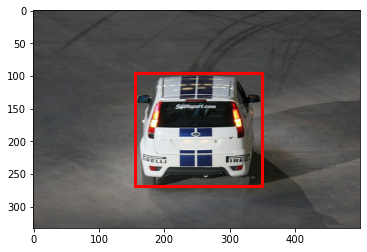

In [24]:
draw_bb(first_data[0], first_data[1], first_data[2], True)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x366 at 0x7FB89EB9F130>, array([[  8, 106, 498, 262],
       [420, 199, 481, 225],
       [324, 187, 410, 222]], dtype=int32), ['aeroplane', 'aeroplane', 'aeroplane'])


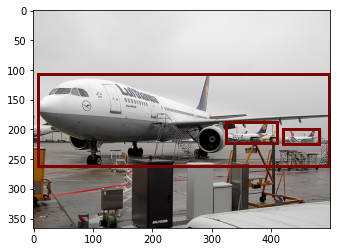

In [29]:
next_data = next(pascal_it)
print(next_data)
draw_bb(next_data[0], next_data[1], next_data[2])